# Chlamydia prevalence estimates with slower natural clearance

A criticism of the original prevalence estimates was that they used a fast rate for the clearance of untreated infection. This notebook investigates the behaviour of prevalence estimates when duration of untreated infection follows a mixture-of-exponentials ditribution as proposed by Price _et al._ in _Statist. Med._ **32**:1547-1560 (2013).

## The five-compartment model

We use a five-compartment model, in which individuals are uninfected (U), infected-asymptomatic (A), infected-symptomatic (S), and infections can be either fast-clearing (f) or slow-clearing (s). The five compartments are denoted:
* U: uninfected
* Af: infected, asymptomatic, fast-clearing
* As: infected, asymptomatic, slow-clearing
* Sf: infected, symptomatic, fast-clearing
* Ss: infected, asymptomatic, slow-clearing

Begin by setting up and solving the ODE model:


In [1]:
from numpy import *
from sympy import *

##############################
# function to calculate steady-state A, U and S
##############################

Af, As, U, Sf, Ss = symbols("Af As U Sf Ss")
alpha_UAf, alpha_UAs, alpha_AfU, alpha_AsU, alpha_USf, alpha_USs, alpha_SfU, alpha_SsU  = symbols("alpha_UAf alpha_UAs alpha_AfU alpha_AsU alpha_USf alpha_USs alpha_SfU alpha_SsU")

model_dyn = [
    alpha_UAf*U - alpha_AfU*Af, # asymptomatic infected fast clearance
    alpha_UAs*U - alpha_AsU*As, # asymptomatic infected slow clearance
    alpha_AfU*Af + alpha_SfU*Sf + alpha_AsU*As + alpha_SsU*Ss - (alpha_UAf + alpha_UAs + alpha_USf + alpha_USs)*U, # uninfected
    alpha_USf*U - alpha_SfU*Sf, # symptomatic infected fast clearance
    alpha_USs*U - alpha_SsU*Ss, # symptomatic infected slow clearance
    Af + As + U + Sf + Ss - 1
    ]

sol_dyn = solve(model_dyn, Af, As, U, Sf, Ss)
print sol_dyn

{As: alpha_AfU*alpha_SfU*alpha_SsU*alpha_UAs/(alpha_AfU*alpha_AsU*alpha_SfU*alpha_SsU + alpha_AfU*alpha_AsU*alpha_SfU*alpha_USs + alpha_AfU*alpha_AsU*alpha_SsU*alpha_USf + alpha_AfU*alpha_SfU*alpha_SsU*alpha_UAs + alpha_AsU*alpha_SfU*alpha_SsU*alpha_UAf), Af: alpha_AsU*alpha_SfU*alpha_SsU*alpha_UAf/(alpha_AfU*alpha_AsU*alpha_SfU*alpha_SsU + alpha_AfU*alpha_AsU*alpha_SfU*alpha_USs + alpha_AfU*alpha_AsU*alpha_SsU*alpha_USf + alpha_AfU*alpha_SfU*alpha_SsU*alpha_UAs + alpha_AsU*alpha_SfU*alpha_SsU*alpha_UAf), U: alpha_AfU*alpha_AsU*alpha_SfU*alpha_SsU/(alpha_AfU*alpha_AsU*alpha_SfU*alpha_SsU + alpha_AfU*alpha_AsU*alpha_SfU*alpha_USs + alpha_AfU*alpha_AsU*alpha_SsU*alpha_USf + alpha_AfU*alpha_SfU*alpha_SsU*alpha_UAs + alpha_AsU*alpha_SfU*alpha_SsU*alpha_UAf), Ss: alpha_AfU*alpha_AsU*alpha_SfU*alpha_USs/(alpha_AfU*alpha_AsU*alpha_SfU*alpha_SsU + alpha_AfU*alpha_AsU*alpha_SfU*alpha_USs + alpha_AfU*alpha_AsU*alpha_SsU*alpha_USf + alpha_AfU*alpha_SfU*alpha_SsU*alpha_UAs + alpha_AsU*alpha_SfU*al

In [2]:
U_fun = lambdify((alpha_UAf, alpha_UAs, alpha_AfU, alpha_AsU, alpha_USf, alpha_USs, alpha_SfU, alpha_SsU), sol_dyn[U])
Af_fun = lambdify((alpha_UAf, alpha_UAs, alpha_AfU, alpha_AsU, alpha_USf, alpha_USs, alpha_SfU, alpha_SsU), sol_dyn[Af])
As_fun = lambdify((alpha_UAf, alpha_UAs, alpha_AfU, alpha_AsU, alpha_USf, alpha_USs, alpha_SfU, alpha_SsU), sol_dyn[As])
Sf_fun = lambdify((alpha_UAf, alpha_UAs, alpha_AfU, alpha_AsU, alpha_USf, alpha_USs, alpha_SfU, alpha_SsU), sol_dyn[Sf])
Ss_fun = lambdify((alpha_UAf, alpha_UAs, alpha_AfU, alpha_AsU, alpha_USf, alpha_USs, alpha_SfU, alpha_SsU), sol_dyn[Ss])
dyn_fun = lambdify((alpha_UAf, alpha_UAs, alpha_AfU, alpha_AsU, alpha_USf, alpha_USs, alpha_SfU, alpha_SsU), 1 - sol_dyn[U])

Now set up the observation model. There are two versions. The first returns two estimates: for the testing and diagnosis rates per person per year:

In [3]:
##############################
# now the model for observed testing and diagnosis rates
##############################

tsym, dsym, ssym, test_sym, true_pos, false_pos = symbols("tsym dsym ssym test_sym true_pos false_pos")

model_test_diag = [
    tsym - ( ssym + (1 - Af - As - U)*test_sym ), # total testing rate
    dsym - ( (Af + As)*ssym*true_pos + U*ssym*false_pos + (1 - Af - As - U)*test_sym*true_pos ) # total diagnosis rate
    ]

sol_prev = solve(model_test_diag, ssym, U)
sol_test_diag = solve(model_test_diag, tsym, dsym)
test_fun = lambdify((Af, As, U, ssym, test_sym, true_pos, false_pos), sol_test_diag[tsym])
diag_fun = lambdify((Af, As, U, ssym, test_sym, true_pos, false_pos), sol_test_diag[dsym])

def test_diag_fun(parms):
    # parms = (incidence, screening rate, proportion symptomatic, self-cure rate, testing rate in symptomatics, true positive rate, false positive rate, ...)
    inc = parms[0]
    scr = parms[1]
    p_symp = parms[2]
    p_fast = parms[3]
    self_cure_f = parms[4]
    self_cure_s = parms[5]
    test_sym = parms[6]
    true_pos = parms[7]
    false_pos = parms[8]
    
    Af = Af_fun(inc*(1-p_symp)*p_fast, inc*(1-p_symp)*(1-p_fast), self_cure_f + scr*true_pos, self_cure_s + scr*true_pos, inc*p_symp*p_fast, inc*p_symp*(1-p_fast), self_cure_f + scr*true_pos + test_sym*true_pos, self_cure_s + scr*true_pos + test_sym*true_pos)
    As = As_fun(inc*(1-p_symp)*p_fast, inc*(1-p_symp)*(1-p_fast), self_cure_f + scr*true_pos, self_cure_s + scr*true_pos, inc*p_symp*p_fast, inc*p_symp*(1-p_fast), self_cure_f + scr*true_pos + test_sym*true_pos, self_cure_s + scr*true_pos + test_sym*true_pos)
    U = U_fun(inc*(1-p_symp)*p_fast, inc*(1-p_symp)*(1-p_fast), self_cure_f + scr*true_pos, self_cure_s + scr*true_pos, inc*p_symp*p_fast, inc*p_symp*(1-p_fast), self_cure_f + scr*true_pos + test_sym*true_pos, self_cure_s + scr*true_pos + test_sym*true_pos)
    return [test_fun(Af, As, U, scr, test_sym, true_pos, false_pos), diag_fun(Af, As, U, scr, test_sym, true_pos, false_pos)]
    

The second observation model returns testing and diagnosis rates per year, and as a third output the prevalence of symptoms among those who are infected. 

In [5]:
# write a different function, which returns also the prevalence of symptoms, amongst those infected
def test_diag_prev_symp_fun(parms):
    # parms = (incidence, screening rate, proportion symptomatic, self-cure rate, testing rate in symptomatics, true positive rate, false positive rate, ...)
    inc = parms[0]
    scr = parms[1]
    p_symp = parms[2]
    p_fast = parms[3]
    self_cure_f = parms[4]
    self_cure_s = parms[5]
    test_sym = parms[6]
    true_pos = parms[7]
    false_pos = parms[8]
    
    Af = Af_fun(inc*(1-p_symp)*p_fast, inc*(1-p_symp)*(1-p_fast), self_cure_f + scr*true_pos, self_cure_s + scr*true_pos, inc*p_symp*p_fast, inc*p_symp*(1-p_fast), self_cure_f + scr*true_pos + test_sym*true_pos, self_cure_s + scr*true_pos + test_sym*true_pos)
    As = As_fun(inc*(1-p_symp)*p_fast, inc*(1-p_symp)*(1-p_fast), self_cure_f + scr*true_pos, self_cure_s + scr*true_pos, inc*p_symp*p_fast, inc*p_symp*(1-p_fast), self_cure_f + scr*true_pos + test_sym*true_pos, self_cure_s + scr*true_pos + test_sym*true_pos)
    U = U_fun(inc*(1-p_symp)*p_fast, inc*(1-p_symp)*(1-p_fast), self_cure_f + scr*true_pos, self_cure_s + scr*true_pos, inc*p_symp*p_fast, inc*p_symp*(1-p_fast), self_cure_f + scr*true_pos + test_sym*true_pos, self_cure_s + scr*true_pos + test_sym*true_pos)
    return [
        test_fun(Af, As, U, scr, test_sym, true_pos, false_pos), 
        diag_fun(Af, As, U, scr, test_sym, true_pos, false_pos),
        (1 - Af - As - U)/(1 - U)]
    

## Sampling for chlamydia prevalence

We are now ready to calculate chlamydia prevalence. Begin by generating samples for quantities common to all subsequent estimates:

In [6]:
from numpy import *
from scipy.optimize import fsolve
n_sample = 10000
rs = random.RandomState(12345)

In [7]:
sc_f = 120*ones(n_sample) # rate of clearance for short infections, see Price et al.
p_true_pos_f = rs.beta(129+1, 12+1, size=n_sample) # Low Health Technol Assess (2007): 129 of 141 infected samples tested +ve
p_false_pos_f = rs.beta(4+1, 2323+1, size=n_sample) # Low Health Technol Assess (2007): 4 of 2327 uninfected samples tested +ve

The clearance rate of slow infections and the proportion of infections which are fast-clearing have been sampled in using STAN, following the methods described in Price _et al._. They are read in here:

In [8]:
sc_s = empty(n_sample) # rate of clearance of slow infections
p_fast = empty(n_sample) # proportion of infections clearing fast

import csv
with open('../chlamydia_two_exponentials_init0_130516.csv', 'rU') as f:
    reader = csv.reader(f)
    reader.next() # skip header row
    i=0
    for row in reader:
        if i < n_sample:
            #print row
            sc_s[i] = row[0]
            p_fast[i] = row[1]
            i = i+1

Sample for the rate of treatment seeking by symptomatic cases:

In [9]:
from scipy.stats import beta

# Find beta distributions corresponding to 95% CIs reported in Mercer Sex. Transm. Infect. (2007) (see table above).

a = empty(5)
b = empty(5)

# < 1 week
[a[0], b[0]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.144, 0.442),
    [1,1]
    )

# 7-13 days
[a[1], b[1]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.061, 0.302),
    [1,1]
    )

# 14-27 days
[a[2], b[2]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.133, 0.310),
    [1,1]
    )

# 28-41 days
[a[3], b[3]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.085, 0.299),
    [1,1]
    )

# 42 days and over
[a[4], b[4]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.055, 0.564),
    [1,1]
    )

# Metropolis-Hastings to get a sample for rate of treatment

i = 0
att_symp = empty(n_sample+1000) # testing rate per person per year. Allow 1000 extra samples for burn-in
ll = empty(n_sample+1000) # log-likelihood
props = empty([n_sample+1000, 5]) # simulated data, for posterior predictive check
old = 0.04 # starting sample value
new = 0.04 # starting sample value

# simulate probabilities corresponding to data

# proportion expected in each time window
tps = array([0., 7., 14., 28., 42., Inf])
simp_old = exp(-old*tps[:5]) - exp(-old*tps[1:])
simp_new = exp(-new*tps[:5]) - exp(-new*tps[1:])

acc=0.
while i < n_sample+1000: # to do samples for p_test_symp
    
    new = rs.normal(old, 0.05) # generate a sample from normal distribution
    
    if new < 0:
        att_symp[i] = old # reject
        ll[i] = -1e10
    else:
        simp_old = exp(-old*tps[:5]) - exp(-old*tps[1:])
        simp_new = exp(-new*tps[:5]) - exp(-new*tps[1:])

        if sum(simp_new > 0) != len(tps) - 1:
            att_symp[i] = old # reject
            ll[i] = -1e10
        else:
            # simulate probabilities corresponding to the data
            log_ratio = sum(beta.logpdf(simp_new, a, b, loc=0, scale=1)) - sum(beta.logpdf(simp_old, a, b, loc=0, scale=1))
    
            if log(rs.uniform(0,1)) <  log_ratio:
                att_symp[i] = new # accept
                ll[i] = sum(beta.logpdf(simp_new, a, b, loc=0, scale=1))
                old = new
                acc = acc+1
            else:
                att_symp[i] = old # reject
                ll[i] = sum(beta.logpdf(simp_old, a, b, loc=0, scale=1))
    
    props[i] = simp_old
    i = i+1
    
att_symp = att_symp[1000:] # remove burn-in samples
ll = ll[1000:] # log-likelihood
    
print acc/(n_sample+1000) # print the proportion of samples accepted
print mean(att_symp)*365.25
print array(percentile(att_symp, [2.5, 97.5]))*365.25

att_symp = att_symp*365.25 # convert rate from day^-1 to year^-1

0.225272727273
14.4234720037
[  8.34629731  22.57604008]


In [11]:
# women, 16-24
[alpha_f_16_24, beta_f_16_24] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.7998634469, 0.837979601),
    [1,1]
    )
p_active_f_16_24 = rs.beta(alpha_f_16_24, beta_f_16_24, size=n_sample) # 16-24 yo only
pop_active_f_15_24 = rs.binomial(3388842, p_active_f_16_24, size=n_sample)

diag_rate_f_15_24 = rs.gamma(88101, 1, size=n_sample)/pop_active_f_15_24
test_rate_f_15_24 = rs.gamma(1205896, 1, size=n_sample)/pop_active_f_15_24

In [12]:
# women, 16-19
[alpha_f_16_19, beta_f_16_19] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.6583593, 0.723554878),
    [1,1]
    )
p_active_f_16_19 = rs.beta(alpha_f_16_19, beta_f_16_19, size=n_sample) # 16-19 yo only
pop_active_f_15_19 = rs.binomial(1600686, p_active_f_16_19, size=n_sample)

diag_rate_f_15_19 = rs.gamma(42874, 1, size=n_sample)/pop_active_f_15_19
test_rate_f_15_19 = rs.gamma(520358, 1, size=n_sample)/pop_active_f_15_19

In [13]:
# women, 20-24
[alpha_f_20_24, beta_f_20_24] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.8904135, 0.934417684),
    [1,1]
    )
p_active_f_20_24 = rs.beta(alpha_f_20_24, beta_f_20_24, size=n_sample) # 20-24 yo only
pop_active_f_20_24 = rs.binomial(1788156, p_active_f_20_24, size=n_sample)

diag_rate_f_20_24 = rs.gamma(45227, 1, size=n_sample)/pop_active_f_20_24
test_rate_f_20_24 = rs.gamma(685538, 1, size=n_sample)/pop_active_f_20_24

### Kahn estimates for prevalence of symptoms

Kahn _et al._ (Sex Transm Dis; 2003) observed symptoms in 135 of 161 female chlamydia patients. Using this as a direct estimate of the proportion of infections which will develop symptoms gives rather low prevalence estimates:

In [18]:
p_asymp_f = rs.beta(135 + 1, 26 + 1, size=n_sample) # Kahn et al. Sex Transm Dis (2003) 84% NB numbers taken from text, p656
#p_asymp_f = rs.beta(42, 22, size=n_sample) # Natsal-3
# sample from beta distributions based on Natsal
# women
# [a_f, b_f] = fsolve(
#     lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
#     - (0.4301738 , 0.7380273),
#     [1,1]
#     )
# p_asymp_f = rs.beta(a_f, b_f, size=n_sample) # 16-19 yo only

In [19]:
prev_f_15_24 = zeros(n_sample)
inc_f_15_24 = zeros(n_sample)
scr_f_15_24 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_15_24[i], scr_f_15_24[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_f[i], # proportion of incident infections which are symptomatic
                            p_fast[i], # proportion of incident infections which clear fast
                            sc_f[i], # fast rate of self-clear 
                            sc_s[i], # slow rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_15_24[i],diag_rate_f_15_24[i]]), [0.03, 0.44])
    prev_f_15_24[i] = dyn_fun(
        inc_f_15_24[i]*p_asymp_f[i]*p_fast[i], 
        inc_f_15_24[i]*p_asymp_f[i]*(1-p_fast[i]), 
        sc_f[i] + scr_f_15_24[i]*p_true_pos_f[i], 
        sc_s[i] + scr_f_15_24[i]*p_true_pos_f[i], 
        inc_f_15_24[i]*(1-p_asymp_f[i])*p_fast[i], 
        inc_f_15_24[i]*(1-p_asymp_f[i])*(1-p_fast[i]), 
        sc_f[i] + scr_f_15_24[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i],
        sc_s[i] + scr_f_15_24[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i]
    )

In [20]:
prev_f_15_19 = zeros(n_sample)
inc_f_15_19 = zeros(n_sample)
scr_f_15_19 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_15_19[i], scr_f_15_19[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_f[i], # proportion of incident infections which are symptomatic
                            p_fast[i], # proportion of incident infections which clear fast
                            sc_f[i], # fast rate of self-clear 
                            sc_s[i], # slow rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_15_19[i],diag_rate_f_15_19[i]]), [0.03, 0.44])
    prev_f_15_19[i] = dyn_fun(
        inc_f_15_19[i]*p_asymp_f[i]*p_fast[i], 
        inc_f_15_19[i]*p_asymp_f[i]*(1-p_fast[i]), 
        sc_f[i] + scr_f_15_19[i]*p_true_pos_f[i], 
        sc_s[i] + scr_f_15_19[i]*p_true_pos_f[i], 
        inc_f_15_19[i]*(1-p_asymp_f[i])*p_fast[i], 
        inc_f_15_19[i]*(1-p_asymp_f[i])*(1-p_fast[i]), 
        sc_f[i] + scr_f_15_19[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i],
        sc_s[i] + scr_f_15_19[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i]
    )

In [21]:
prev_f_20_24 = zeros(n_sample)
inc_f_20_24 = zeros(n_sample)
scr_f_20_24 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_20_24[i], scr_f_20_24[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_f[i], # proportion of incident infections which are symptomatic
                            p_fast[i], # proportion of incident infections which clear fast
                            sc_f[i], # fast rate of self-clear 
                            sc_s[i], # slow rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_20_24[i],diag_rate_f_20_24[i]]), [0.03, 0.44])
    prev_f_20_24[i] = dyn_fun(
        inc_f_20_24[i]*p_asymp_f[i]*p_fast[i], 
        inc_f_20_24[i]*p_asymp_f[i]*(1-p_fast[i]), 
        sc_f[i] + scr_f_20_24[i]*p_true_pos_f[i], 
        sc_s[i] + scr_f_20_24[i]*p_true_pos_f[i], 
        inc_f_20_24[i]*(1-p_asymp_f[i])*p_fast[i], 
        inc_f_20_24[i]*(1-p_asymp_f[i])*(1-p_fast[i]), 
        sc_f[i] + scr_f_20_24[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i],
        sc_s[i] + scr_f_20_24[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i]
    )

median for sexually active women, 15-24 years: 0.0531937047753
95% CI for sexually active women, 15-24 years: 0.0453923724642 0.0608784228593


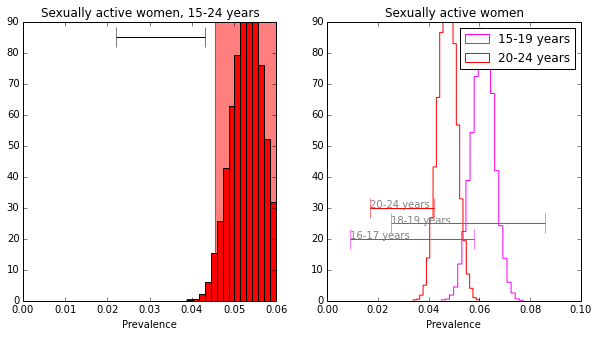

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (10,5))

ax1 = fig.add_subplot(121)
h_2012_f_15_24 = ax1.hist(prev_f_15_24, range=[min(prev_f_15_24),max(prev_f_15_24)], bins=20, normed=true, color='r')
ax1.fill_betweenx([0,100], percentile(prev_f_15_24, 2.5), percentile(prev_f_15_24, 97.5), facecolor='r', alpha=0.5)
ax1.errorbar(0.022, 85, xerr=[[0],[0.043-0.022]], ecolor='k', capsize=10)
ax1.set_xlabel('Prevalence')
ax1.set_xlim(0,0.06)
ax1.set_ylim(0,90)
ax1.set_title('Sexually active women, 15-24 years')

ax2 = fig.add_subplot(122)
h_2012_f_15_19 = ax2.hist(prev_f_15_19, range=[min(prev_f_15_19),max(prev_f_15_19)], bins=20, normed=true, histtype='step', color='fuchsia', label='15-19 years')
h_2012_f_20_24 = ax2.hist(prev_f_20_24, range=[min(prev_f_20_24),max(prev_f_20_24)], bins=20, normed=true, histtype='step', color='r', label='20-24 years')
ax2.errorbar(0.009, 20, xerr=[[0],[0.058-0.009]], ecolor='fuchsia', capsize=10)
ax2.errorbar(0.025, 25, xerr=[[0],[0.086-0.025]], ecolor='fuchsia', capsize=10)
ax2.errorbar(0.017, 30, xerr=[[0],[0.042-0.017]], ecolor='r', capsize=10)
ax2.annotate('16-17 years', [0.009, 20], color='0.5')
ax2.annotate('18-19 years', [0.025, 25], color='0.5')
ax2.annotate('20-24 years', [0.017, 30], color='0.5')
ax2.set_xlabel('Prevalence')
ax2.set_xlim(0,0.1)
ax2.set_ylim(0,90)
ax2.set_title('Sexually active women')
ax2.legend()

print 'median for sexually active women, 15-24 years:', percentile(prev_f_15_24, 50)
print '95% CI for sexually active women, 15-24 years:', percentile(prev_f_15_24, 2.5), percentile(prev_f_15_24, 97.5)

It is not appropriate to use the Kahn data for the prevalence of symptoms in infected people, because the study was conducted in a different setting from Natsal-3 (a mobile screening unit in the urban US).

### Natsal-3 data on prevalence of symptoms

Natsal-3 asked participants about STI symptoms they had experienced in the last month. Combined with age and chlamydia testing data, this provides information on the prevalence of infection in those who tested positive for chlamydia. However, symptoms were not a specific indicator of infection, with several uninfected participants also reporting symptoms. 

We start by using the prevalence of symptoms across all infected individuals as an estimate of the proportion of incident infections causing symptoms.

In [23]:
p_asymp_f = rs.beta(42, 22, size=n_sample) # Natsal-3; all infected women

In [24]:
prev_f_15_24 = zeros(n_sample)
inc_f_15_24 = zeros(n_sample)
scr_f_15_24 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_15_24[i], scr_f_15_24[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_f[i], # proportion of incident infections which are symptomatic
                            p_fast[i], # proportion of incident infections which clear fast
                            sc_f[i], # fast rate of self-clear 
                            sc_s[i], # slow rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_15_24[i],diag_rate_f_15_24[i]]), [0.03, 0.44])
    prev_f_15_24[i] = dyn_fun(
        inc_f_15_24[i]*p_asymp_f[i]*p_fast[i], 
        inc_f_15_24[i]*p_asymp_f[i]*(1-p_fast[i]), 
        sc_f[i] + scr_f_15_24[i]*p_true_pos_f[i], 
        sc_s[i] + scr_f_15_24[i]*p_true_pos_f[i], 
        inc_f_15_24[i]*(1-p_asymp_f[i])*p_fast[i], 
        inc_f_15_24[i]*(1-p_asymp_f[i])*(1-p_fast[i]), 
        sc_f[i] + scr_f_15_24[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i],
        sc_s[i] + scr_f_15_24[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i]
    )

In [25]:
prev_f_15_19 = zeros(n_sample)
inc_f_15_19 = zeros(n_sample)
scr_f_15_19 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_15_19[i], scr_f_15_19[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_f[i], # proportion of incident infections which are symptomatic
                            p_fast[i], # proportion of incident infections which clear fast
                            sc_f[i], # fast rate of self-clear 
                            sc_s[i], # slow rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_15_19[i],diag_rate_f_15_19[i]]), [0.03, 0.44])
    prev_f_15_19[i] = dyn_fun(
        inc_f_15_19[i]*p_asymp_f[i]*p_fast[i], 
        inc_f_15_19[i]*p_asymp_f[i]*(1-p_fast[i]), 
        sc_f[i] + scr_f_15_19[i]*p_true_pos_f[i], 
        sc_s[i] + scr_f_15_19[i]*p_true_pos_f[i], 
        inc_f_15_19[i]*(1-p_asymp_f[i])*p_fast[i], 
        inc_f_15_19[i]*(1-p_asymp_f[i])*(1-p_fast[i]), 
        sc_f[i] + scr_f_15_19[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i],
        sc_s[i] + scr_f_15_19[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i]
    )

In [26]:
prev_f_20_24 = zeros(n_sample)
inc_f_20_24 = zeros(n_sample)
scr_f_20_24 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_20_24[i], scr_f_20_24[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_f[i], # proportion of incident infections which are symptomatic
                            p_fast[i], # proportion of incident infections which clear fast
                            sc_f[i], # fast rate of self-clear 
                            sc_s[i], # slow rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_20_24[i],diag_rate_f_20_24[i]]), [0.03, 0.44])
    prev_f_20_24[i] = dyn_fun(
        inc_f_20_24[i]*p_asymp_f[i]*p_fast[i], 
        inc_f_20_24[i]*p_asymp_f[i]*(1-p_fast[i]), 
        sc_f[i] + scr_f_20_24[i]*p_true_pos_f[i], 
        sc_s[i] + scr_f_20_24[i]*p_true_pos_f[i], 
        inc_f_20_24[i]*(1-p_asymp_f[i])*p_fast[i], 
        inc_f_20_24[i]*(1-p_asymp_f[i])*(1-p_fast[i]), 
        sc_f[i] + scr_f_20_24[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i],
        sc_s[i] + scr_f_20_24[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i]
    )

median for sexually active women, 15-24 years: 0.0350873569009
95% CI for sexually active women, 15-24 years: 0.0257907739977 0.0456728080073


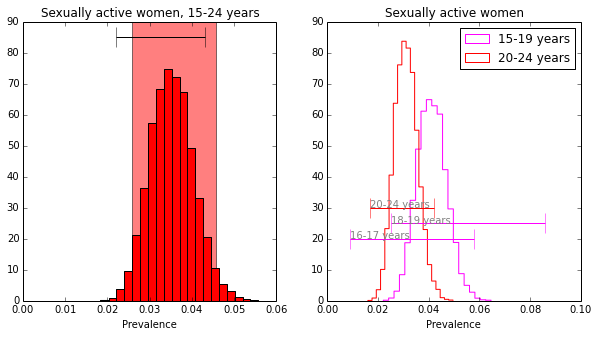

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (10,5))

ax1 = fig.add_subplot(121)
h_2012_f_15_24 = ax1.hist(prev_f_15_24, range=[min(prev_f_15_24),max(prev_f_15_24)], bins=20, normed=true, color='r')
ax1.fill_betweenx([0,100], percentile(prev_f_15_24, 2.5), percentile(prev_f_15_24, 97.5), facecolor='r', alpha=0.5)
ax1.errorbar(0.022, 85, xerr=[[0],[0.043-0.022]], ecolor='k', capsize=10)
ax1.set_xlabel('Prevalence')
ax1.set_xlim(0,0.06)
ax1.set_ylim(0,90)
ax1.set_title('Sexually active women, 15-24 years')

ax2 = fig.add_subplot(122)
h_2012_f_15_19 = ax2.hist(prev_f_15_19, range=[min(prev_f_15_19),max(prev_f_15_19)], bins=20, normed=true, histtype='step', color='fuchsia', label='15-19 years')
h_2012_f_20_24 = ax2.hist(prev_f_20_24, range=[min(prev_f_20_24),max(prev_f_20_24)], bins=20, normed=true, histtype='step', color='r', label='20-24 years')
ax2.errorbar(0.009, 20, xerr=[[0],[0.058-0.009]], ecolor='fuchsia', capsize=10)
ax2.errorbar(0.025, 25, xerr=[[0],[0.086-0.025]], ecolor='fuchsia', capsize=10)
ax2.errorbar(0.017, 30, xerr=[[0],[0.042-0.017]], ecolor='r', capsize=10)
ax2.annotate('16-17 years', [0.009, 20], color='0.5')
ax2.annotate('18-19 years', [0.025, 25], color='0.5')
ax2.annotate('20-24 years', [0.017, 30], color='0.5')
ax2.set_xlabel('Prevalence')
ax2.set_xlim(0,0.1)
ax2.set_ylim(0,90)
ax2.set_title('Sexually active women')
ax2.legend()

print 'median for sexually active women, 15-24 years:', percentile(prev_f_15_24, 50)
print '95% CI for sexually active women, 15-24 years:', percentile(prev_f_15_24, 2.5), percentile(prev_f_15_24, 97.5)

These estimates agree well with Natsal-3.

It would arguably be more appropriate to interpret this data as information about the prevalence of symptoms amongst prevalent infections. This is acheived using the second function. We must use data from only the appropriate age group, as different incidence and testing patterns affect the balance between asymptomatic and symptomatic infections at steady-state.

In [28]:
p_asymp_f_15_24 = rs.beta(24, 15, size=n_sample) # Natsal-3

p_symp_f_15_24 = zeros(n_sample)
prev_f_15_24 = zeros(n_sample)
inc_f_15_24 = zeros(n_sample)
scr_f_15_24 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_15_24[i], scr_f_15_24[i], p_symp_f_15_24[i]] = fsolve(lambda x: test_diag_prev_symp_fun(concatenate([
                    x, array([
                            p_fast[i], # proportion of incident infections which clear fast
                            sc_f[i], # fast rate of self-clear 
                            sc_s[i], # slow rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_15_24[i],diag_rate_f_15_24[i], 1-p_asymp_f_15_24[i]]), [0.09, 0.25, 0.8])
    prev_f_15_24[i] = dyn_fun(
        inc_f_15_24[i]*p_asymp_f_15_24[i]*p_fast[i], 
        inc_f_15_24[i]*p_asymp_f_15_24[i]*(1-p_fast[i]), 
        sc_f[i] + scr_f_15_24[i]*p_true_pos_f[i], 
        sc_s[i] + scr_f_15_24[i]*p_true_pos_f[i], 
        inc_f_15_24[i]*(1-p_asymp_f_15_24[i])*p_fast[i], 
        inc_f_15_24[i]*(1-p_asymp_f_15_24[i])*(1-p_fast[i]), 
        sc_f[i] + scr_f_15_24[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i],
        sc_s[i] + scr_f_15_24[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i]
    )

In [29]:
p_asymp_f_15_19 = rs.beta(10, 8, size=n_sample) # Natsal-3

p_symp_f_15_19 = zeros(n_sample)
prev_f_15_19 = zeros(n_sample)
inc_f_15_19 = zeros(n_sample)
scr_f_15_19 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_15_19[i], scr_f_15_19[i], p_symp_f_15_19[i]] = fsolve(lambda x: test_diag_prev_symp_fun(concatenate([
                    x, array([
                            p_fast[i], # proportion of incident infections which clear fast
                            sc_f[i], # fast rate of self-clear 
                            sc_s[i], # slow rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_15_19[i],diag_rate_f_15_19[i], 1-p_asymp_f_15_19[i]]), [0.09, 0.25, 0.8])
    prev_f_15_19[i] = dyn_fun(
        inc_f_15_19[i]*p_asymp_f_15_19[i]*p_fast[i], 
        inc_f_15_19[i]*p_asymp_f_15_19[i]*(1-p_fast[i]), 
        sc_f[i] + scr_f_15_19[i]*p_true_pos_f[i], 
        sc_s[i] + scr_f_15_19[i]*p_true_pos_f[i], 
        inc_f_15_19[i]*(1-p_asymp_f_15_19[i])*p_fast[i], 
        inc_f_15_19[i]*(1-p_asymp_f_15_19[i])*(1-p_fast[i]), 
        sc_f[i] + scr_f_15_19[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i],
        sc_s[i] + scr_f_15_19[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i]
    )

In [30]:
p_asymp_f_20_24 = rs.beta(15, 8, size=n_sample) # Natsal-3

p_symp_f_20_24 = zeros(n_sample)
prev_f_20_24 = zeros(n_sample)
inc_f_20_24 = zeros(n_sample)
scr_f_20_24 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_20_24[i], scr_f_20_24[i], p_symp_f_20_24[i]] = fsolve(lambda x: test_diag_prev_symp_fun(concatenate([
                    x, array([
                            p_fast[i], # proportion of incident infections which clear fast
                            sc_f[i], # fast rate of self-clear 
                            sc_s[i], # slow rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_20_24[i],diag_rate_f_20_24[i], 1-p_asymp_f_20_24[i]]), [0.09, 0.25, 0.8])
    prev_f_20_24[i] = dyn_fun(
        inc_f_20_24[i]*p_asymp_f_20_24[i]*p_fast[i], 
        inc_f_20_24[i]*p_asymp_f_20_24[i]*(1-p_fast[i]), 
        sc_f[i] + scr_f_20_24[i]*p_true_pos_f[i], 
        sc_s[i] + scr_f_20_24[i]*p_true_pos_f[i], 
        inc_f_20_24[i]*(1-p_asymp_f_20_24[i])*p_fast[i], 
        inc_f_20_24[i]*(1-p_asymp_f_20_24[i])*(1-p_fast[i]), 
        sc_f[i] + scr_f_20_24[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i],
        sc_s[i] + scr_f_20_24[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i]
    )

median for sexually active women, 15-24 years: 0.0208060911804
95% CI for sexually active women, 15-24 years: 0.0151675665381 0.027951079541


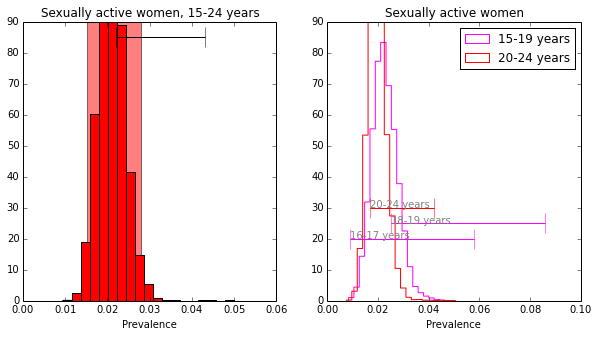

In [31]:
fig = plt.figure(figsize = (10,5))

ax1 = fig.add_subplot(121)
h_2012_f_15_24 = ax1.hist(prev_f_15_24, range=[min(prev_f_15_24),max(prev_f_15_24)], bins=20, normed=true, color='r')
ax1.fill_betweenx([0,100], percentile(prev_f_15_24, 2.5), percentile(prev_f_15_24, 97.5), facecolor='r', alpha=0.5)
ax1.errorbar(0.022, 85, xerr=[[0],[0.043-0.022]], ecolor='k', capsize=10)
ax1.set_xlabel('Prevalence')
ax1.set_xlim(0,0.06)
ax1.set_ylim(0,90)
ax1.set_title('Sexually active women, 15-24 years')

ax2 = fig.add_subplot(122)
h_2012_f_15_19 = ax2.hist(prev_f_15_19, range=[min(prev_f_15_19),max(prev_f_15_19)], bins=20, normed=true, histtype='step', color='fuchsia', label='15-19 years')
h_2012_f_20_24 = ax2.hist(prev_f_20_24, range=[min(prev_f_20_24),max(prev_f_20_24)], bins=20, normed=true, histtype='step', color='r', label='20-24 years')
ax2.errorbar(0.009, 20, xerr=[[0],[0.058-0.009]], ecolor='fuchsia', capsize=10)
ax2.errorbar(0.025, 25, xerr=[[0],[0.086-0.025]], ecolor='fuchsia', capsize=10)
ax2.errorbar(0.017, 30, xerr=[[0],[0.042-0.017]], ecolor='r', capsize=10)
ax2.annotate('16-17 years', [0.009, 20], color='0.5')
ax2.annotate('18-19 years', [0.025, 25], color='0.5')
ax2.annotate('20-24 years', [0.017, 30], color='0.5')
ax2.set_xlabel('Prevalence')
ax2.set_xlim(0,0.1)
ax2.set_ylim(0,90)
ax2.set_title('Sexually active women')
ax2.legend()

print 'median for sexually active women, 15-24 years:', percentile(prev_f_15_24, 50)
print '95% CI for sexually active women, 15-24 years:', percentile(prev_f_15_24, 2.5), percentile(prev_f_15_24, 97.5)

These estimates overlap with the Natsal-3 confidence intervals, but are consistently lower.